In [1]:
import os
from pathlib import Path
os.chdir(Path().cwd().parent)

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

sns.set_style('whitegrid')
sns.set_palette(sns.color_palette('muted'))
sns.set_context(sns.plotting_context('notebook', font_scale=1.3))
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')

# Objectives


Research questions
----------
1. Which features strongly correlate with the critical temperature required to attain superconductivity?
2. Presence of which elements in the compound generally tends to give the highest critical temperatures for superconductivity?
3. What is the most accurate (or least erroneous) model we can build to predict the critical temperature required for superconductivity for a given compound?


In [3]:
raw = pd.read_csv('dataset/train.csv')
rawelem = pd.read_csv('dataset/unique_m.csv')

In [27]:
raw.head()

,number_of_elements,mean_atomic_mass,wtd_mean_atomic_mass,gmean_atomic_mass,wtd_gmean_atomic_mass,entropy_atomic_mass,wtd_entropy_atomic_mass,range_atomic_mass,wtd_range_atomic_mass,std_atomic_mass,...,wtd_mean_Valence,gmean_Valence,wtd_gmean_Valence,entropy_Valence,wtd_entropy_Valence,range_Valence,wtd_range_Valence,std_Valence,wtd_std_Valence,critical_temp
0,4,88.944468,57.862692,66.361592,36.116612,1.181795,1.062396,122.90607,31.794921,51.968828,...,2.257143,2.213364,2.219783,1.368922,1.066221,1,1.085714,0.433013,0.437059,29.0
1,5,92.729214,58.518416,73.132787,36.396602,1.449309,1.057755,122.90607,36.161939,47.094633,...,2.257143,1.888175,2.210679,1.557113,1.047221,2,1.128571,0.632456,0.468606,26.0
2,4,88.944468,57.885242,66.361592,36.122509,1.181795,0.975980,122.90607,35.741099,51.968828,...,2.271429,2.213364,2.232679,1.368922,1.029175,1,1.114286,0.433013,0.444697,19.0
3,4,88.944468,57.873967,66.361592,36.119560,1.181795,1.022291,122.90607,33.768010,51.968828,...,2.264286,2.213364,2.226222,1.368922,1.048834,1,1.100000,0.433013,0.440952,22.0
4,4,88.944468,57.840143,66.361592,36.110716,1.181795,1.129224,122.90607,27.848743,51.968828,...,2.242857,2.213364,2.206963,1.368922,1.096052,1,1.057143,0.433013,0.428809,23.0


In [5]:
rawelem.head()

,H,He,Li,Be,B,C,N,O,F,Ne,...,Au,Hg,Tl,Pb,Bi,Po,At,Rn,critical_temp,material
0,0.0,0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0,...,0.0,0.0,0.0,0.0,0.0,0,0,0,29.0,Ba0.2La1.8Cu1O4
1,0.0,0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0,...,0.0,0.0,0.0,0.0,0.0,0,0,0,26.0,Ba0.1La1.9Ag0.1Cu0.9O4
2,0.0,0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0,...,0.0,0.0,0.0,0.0,0.0,0,0,0,19.0,Ba0.1La1.9Cu1O4
3,0.0,0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0,...,0.0,0.0,0.0,0.0,0.0,0,0,0,22.0,Ba0.15La1.85Cu1O4
4,0.0,0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0,...,0.0,0.0,0.0,0.0,0.0,0,0,0,23.0,Ba0.3La1.7Cu1O4


## **Q1** | Critical temperature distribution

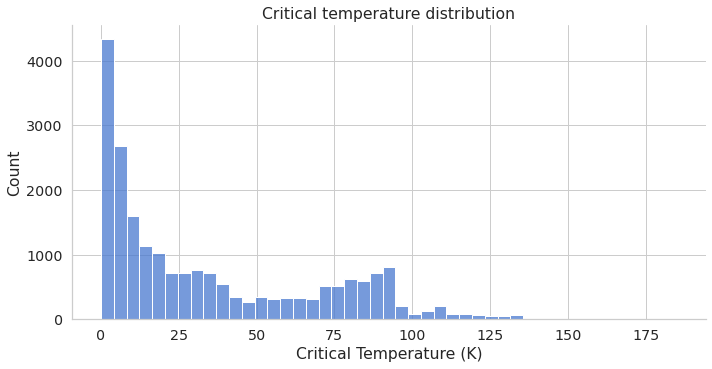

In [6]:
g = sns.displot(raw['critical_temp'], aspect=2)
g.ax.set_title('Critical temperature distribution')
_ = g.ax.set_xlabel('Critical Temperature (K)')

## **Q2** | Feature correlations

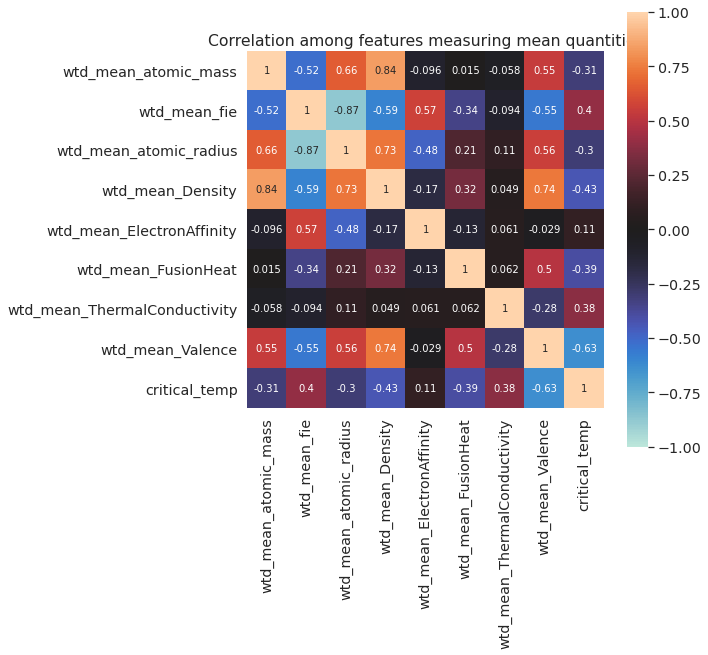

In [7]:
mean_cols = [x for x in raw.columns.tolist() if x.startswith('wtd_mean')]
mean_cols += ['critical_temp']
corrdf = raw[mean_cols].corr()

fig, ax = plt.subplots(figsize=(8, 8))
sns.heatmap(corrdf, center=0, vmin=-1, vmax=1, square=True, ax=ax, annot=True)
_ = ax.set_title('Correlation among features measuring mean quantities')

## **Q3** | Which features are the strongest indicators of critical temperature?

In [8]:
corrdf = (
    raw
    .corr()
    .loc['critical_temp']
    .sort_values(ascending=False, 
                 key=lambda x: np.abs(x))
    .reset_index()
    .rename(columns={'index': 'Features', 'critical_temp': 'Correlations'})
    [1:]
)

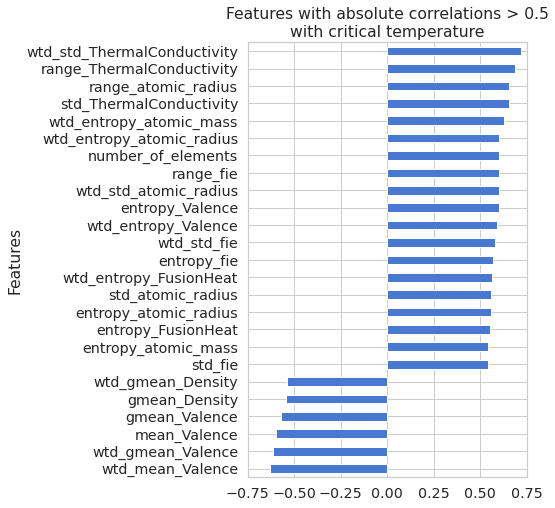

In [9]:
ax = (
    corrdf
    .loc[lambda x: x['Correlations'].abs() >= 0.5]
    .sort_values(by='Correlations')
    .plot(x='Features', 
          y='Correlations',
          figsize=(5, 8),
          kind='barh', 
          legend=False,
          xlim=(-0.75, 0.75),
          title='Features with absolute correlations > 0.5\nwith critical temperature')
)
# ax.grid(False)

## **Q4** | Presence of which elements generally tends to give the highest critical temperatures?

In [10]:
rawelem.head()

,H,He,Li,Be,B,C,N,O,F,Ne,...,Au,Hg,Tl,Pb,Bi,Po,At,Rn,critical_temp,material
0,0.0,0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0,...,0.0,0.0,0.0,0.0,0.0,0,0,0,29.0,Ba0.2La1.8Cu1O4
1,0.0,0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0,...,0.0,0.0,0.0,0.0,0.0,0,0,0,26.0,Ba0.1La1.9Ag0.1Cu0.9O4
2,0.0,0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0,...,0.0,0.0,0.0,0.0,0.0,0,0,0,19.0,Ba0.1La1.9Cu1O4
3,0.0,0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0,...,0.0,0.0,0.0,0.0,0.0,0,0,0,22.0,Ba0.15La1.85Cu1O4
4,0.0,0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0,...,0.0,0.0,0.0,0.0,0.0,0,0,0,23.0,Ba0.3La1.7Cu1O4


In [11]:
element_cols = rawelem.drop(columns=['critical_temp', 'material']).columns.tolist()

presence = (
    rawelem
    .melt(id_vars=['critical_temp', 'material'], var_name='element', value_name='present')
    .assign(present = lambda x: x['present'].astype(bool))
    .loc[lambda x: x['present']]
    .drop(columns=['material', 'present'])
)

In [12]:
presence_info = (
    presence
    .groupby(by='element')
    .agg({
        'critical_temp': ['mean', 'median', 'std', 'min', 'max', 'count']
    })
    .sort_values(by=('critical_temp', 'median'), ascending=False)
)

In [13]:
high_temp_elements = presence_info.head(10).index.tolist()

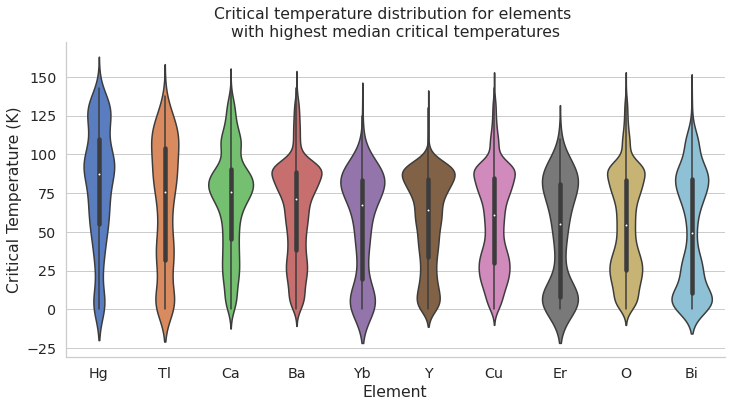

In [14]:
g = sns.catplot(
    x='element', 
    y='critical_temp', 
    data=presence[presence['element'].isin(high_temp_elements)], 
    kind='violin',
    aspect=2,
    order=high_temp_elements,
    palette=sns.color_palette('muted')
)

g.ax.set_xlabel('Element')
g.ax.set_ylabel('Critical Temperature (K)')
_ = g.ax.set_title('Critical temperature distribution for elements \nwith highest median critical temperatures')

## **Q5** | What is the most accurate (or least erroneous) model we can build to predict the critical temperature?

In [16]:
features = raw.drop(columns=['critical_temp']).columns.tolist()

X = raw[features]
y = raw['critical_temp']

X = StandardScaler().fit_transform(X)

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

In [18]:
print(X_train.shape)
print(X_test.shape)

(15947, 81)
(5316, 81)


In [97]:
model_types = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(n_jobs=1),
    'SVM': SVR(),
    'XGB': XGBRegressor(n_jobs=1)
}

grid_search_params = {
    'Linear Regression': {},
    'Random Forest': {
        'n_estimators': [100, 200, 300],
        'max_depth': [11, 15, 19, 23]
    },
    'SVM': {
        'C': [50, 100, 200, 400],
        'kernel': ['linear', 'rbf']
    },
    'XGB': {
        'n_estimators': [100, 200, 400, 700, 1000],
        'max_depth': [2, 4, 7]
    }
}

In [98]:
def get_parameter_description(params):
    s = ''
    for param, value in params.items():
        s += f'{param}: {value} | '
    return s[:-3]

## Grid search flow

```
results = dictionary()


for algorithm in algorithms:
    
    for param_combination in parameters[algorithm]:
    
        regressor = algorithm.initialize(param_combination)
        
        for train_data, valid_data in K_fold_splits(training_data):
        
            regressor.fit(train_data)
        
            results = regressor.evaluate(valid_data)
        
        results[algorithm, param_combination] = mean(results)

```

In [21]:
%%time

result_fields = {
    'model_type',
    'parameters',
    'rmse'
}

best_models = {}

result_dict = {field: [] for field in result_fields}

for model_type in model_types:
    params = grid_search_params[model_type]
#     n_jobs = 28 if model_type == 'XGB' else -1
    gs_model = GridSearchCV(model_types[model_type], 
                            params, 
                            n_jobs=-1,
                            cv=3,
                            scoring='neg_root_mean_squared_error', 
                            verbose=1)
    gs_model.fit(X_train, y_train)
    
    model_results = gs_model.cv_results_
    result_dict['model_type'].extend([model_type] * len(model_results['mean_test_score']))
    result_dict['parameters'].extend([get_parameter_description(x) for x in model_results['params']])
    result_dict['rmse'].extend(model_results['mean_test_score'])
    
    best_models[model_type] = gs_model.best_estimator_

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   36.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.


Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=-1)]: Done  10 out of  36 | elapsed:  2.1min remaining:  5.3min
[Parallel(n_jobs=-1)]: Done  36 out of  36 | elapsed:  4.5min finished


Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done  11 out of  24 | elapsed:   55.1s remaining:  1.1min
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed: 14.8min finished


Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 out of  45 | elapsed:  1.9min remaining:  1.2min
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:  3.9min finished


CPU times: user 4min 40s, sys: 4.57 s, total: 4min 45s
Wall time: 28min 24s


In [22]:
# Compile results into a dataframe

results = (
    pd.DataFrame(result_dict)
    .assign(rmse = lambda x: -1 * x['rmse'])
    [['model_type', 'parameters', 'rmse']]
)

In [105]:
# Check best models for each algorithm

results.groupby(by='model_type').agg({'rmse': 'min'})

,rmse
model_type,
Linear Regression,17.532771
Random Forest,10.015818
SVM,13.060254
XGB,10.383260


In [24]:
results

,model_type,parameters,rmse
0,Linear Regression,,17.532771
1,Random Forest,max_depth: 11 | n_estimators: 100,10.742259
2,Random Forest,max_depth: 11 | n_estimators: 200,10.716281
3,Random Forest,max_depth: 11 | n_estimators: 300,10.706596
4,Random Forest,max_depth: 15 | n_estimators: 100,10.115936
5,Random Forest,max_depth: 15 | n_estimators: 200,10.082049
6,Random Forest,max_depth: 15 | n_estimators: 300,10.090968
7,Random Forest,max_depth: 19 | n_estimators: 100,10.068804
8,Random Forest,max_depth: 19 | n_estimators: 200,10.030014
9,Random Forest,max_depth: 19 | n_estimators: 300,10.015818


In [113]:
summary = (
    results
    .assign(model = lambda x: x['model_type'] + ' | ' + x['parameters'])
)

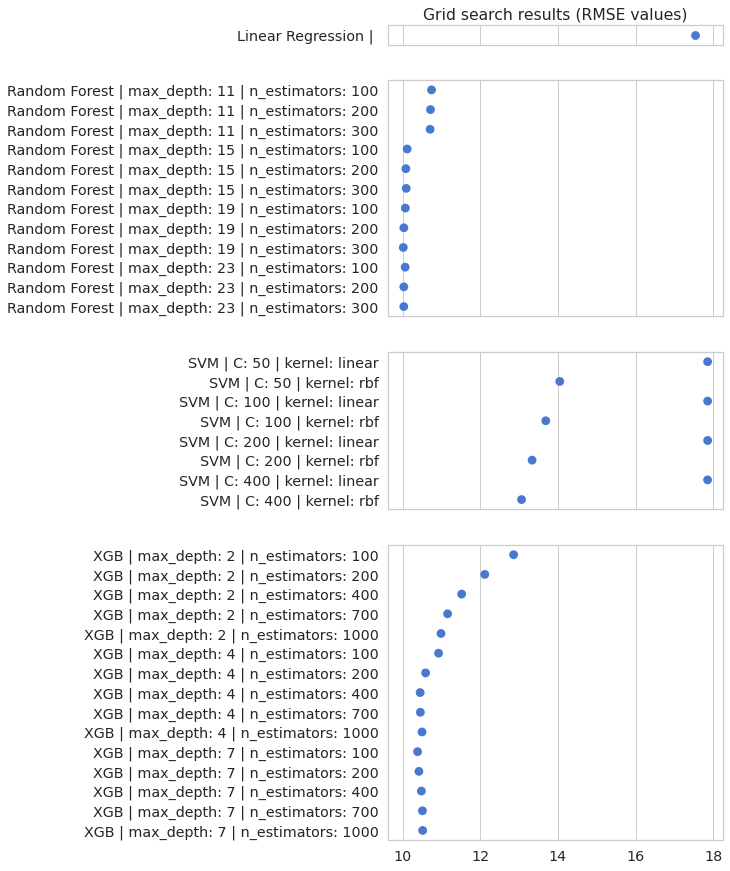

In [104]:
fig, ax = plt.subplots(len(model_types), 1, figsize=(6, 15), sharex=True, gridspec_kw={'height_ratios': [1, 12, 8, 15]})
ax[0].set_title('Grid search results (RMSE values)')

for i, modtype in enumerate(list(model_types.keys())):
    mod_results = summary[summary['model_type'] == modtype]
    sns.pointplot(x='rmse', y='model', data=mod_results, orient='h', join=False, ax=ax[i])
    ax[i].set_ylabel('')
    ax[i].set_xlabel('')

In [25]:
results.to_csv('results.csv', index=False)

In [112]:
# Get test data performance

best_model = best_models['Random Forest']
pred = best_model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, pred))
print(f'RMSE on testing data: {rmse:.4} K')

RMSE on testing data: 9.533 K
